In [1]:
import requests
from bs4 import BeautifulSoup
import re

from config import gaishi, minshuu
from selenium import webdriver
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%matplotlib inline

## 外資就活ドットコム

In [2]:
# session開始
sess = requests.Session()
#res = sess.get("https://gaishishukatsu.com/login")
#soup = BeautifulSoup(res.text, "html.parser")

In [3]:
# formへのpostコンテンツ
payload = {
    " _method": "POST",
    "data[GsUser][email]": gaishi["email"],
    "data[GsUser][password]": gaishi["password"],
}

In [4]:
# login
sess.post("https://gaishishukatsu.com/login", payload)

<Response [200]>

### 以下ログイン後の任意のページを閲覧可能

In [8]:
# 三菱商事のページ
mit = sess.get("https://gaishishukatsu.com/company/37/study")
mit_es_soup = BeautifulSoup(mit.text, "lxml")
mit_es_soup

<!DOCTYPE html>
<html id="ng-app" ng-app="gsskt" prefix="og: http://ogp.me/ns#" xmlns:ng="http://angularjs.org">
<head>
<script id="analytics_user_profile" type="application/json">{"id":"73782","sex":"1","university":"434","major":"200009","bun_ri":"2","grade":"7","graduation_year":"2019","graduate_month":"3","current_univ_type":"graduate","user_registered":"2015-06-22 01:59:09","university_txt":"\u6771\u4eac\u5927\u5b66","major_txt":"\u5de5\u5b66\u7cfb\u7814\u7a76\u79d1","calculated_graduation_year":"2019","sex_txt":"\u7537","bun_ri_txt":"\u7406\u7cfb","grade_txt":"\u4fee\u58eb1\u5e74","current_univ_type_txt":"\u4fee\u58eb","registered":"2015-06-22","is_user_logged_in":"Yes","is_smartphone_view":"No","column_or_recruiting":null}</script>
<script type="text/javascript">
    var element = document.getElementById('analytics_user_profile');
    var parsed = JSON.parse(element.innerHTML);
    dataLayer = [parsed];
</script>
<!-- Google Tag Manager -->
<script>(function(w,d,s,l,i){w[l]=w[l]

In [34]:
def show_capture(driver):
    data = driver.page_source.encode('utf-8')
    driver.save_screenshot("test.png")
    im = Image.open("test.png", "r")
    plt.figure(figsize=(12,40))
    plt.imshow(np.array(im))
    return data

In [27]:
# ログインページへのアクセスとログイン
driver = webdriver.PhantomJS(service_log_path=os.path.devnull)
driver.get("https://gaishishukatsu.com/login")
driver.implicitly_wait(1)
username_field = driver.find_element_by_name("data[GsUser][email]")
password_field = driver.find_element_by_name("data[GsUser][password]")
username_field.send_keys(gaishi["email"])
driver.implicitly_wait(1)
password_field.send_keys(gaishi["password"])
driver.implicitly_wait(1)
driver.find_element_by_css_selector("#GsUserLoginForm > div._mt-md.content-center-button > p:nth-child(1) > button").click()

In [29]:
# 三菱商事のページへES一覧ページへアクセス
driver.get("https://gaishishukatsu.com/company/37/study")
source = show_capture(driver)
es_list_page = BeautifulSoup(source, "lxml")

In [30]:
# ESのURL一覧を取得
selection_reports = []
es_list = es_list_page.find_all("a", class_="_panel-content report-list")
for es in es_list:
    url = es["ng-href"]
    if str(url).startswith("https://gaishishukatsu.com/selection_reports/"):
        selection_reports.append(url)

In [63]:
es_url = selection_reports[0]

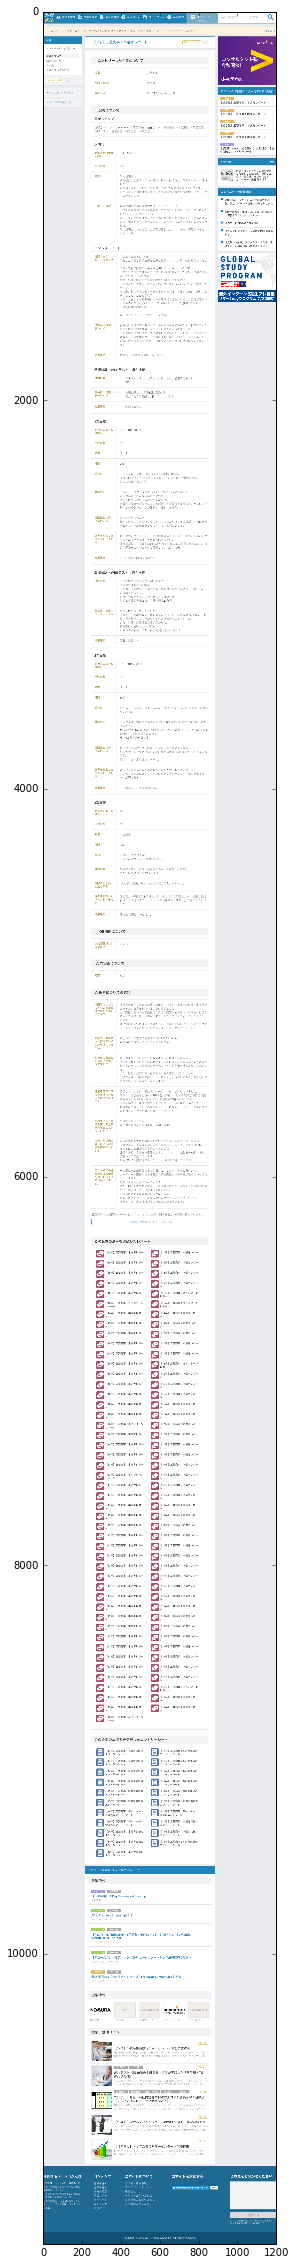

In [64]:
driver.get(es_url)
source = show_capture(driver)
es_page = BeautifulSoup(source, "lxml")

In [80]:
company_sls = {}
for sl_url in selection_reports:
    driver.implicitly_wait(1)
    driver.get(sl_url)
    source = driver.page_source.encode('utf-8')
    sl_page = BeautifulSoup(source, "lxml")
    try:
        importance = sl_page.find("td", class_="impression_importance").text
    except AttributeError:
        importance = ""
    try:
        advice = sl_page.find("td", class_="impression_advice").text
    except:
        advice = ""
    company_sls[sl_url] = {"importance": importance, "advice": advice}

In [82]:
len(company_sls)

94

In [86]:
import json
with open("mitshubishi_shouji.json", "w") as f:
    json.dump(company_sls, f)

In [88]:
with open("mitshubishi_shouji.json", "r") as f:
    x = json.load(f)
x

{'https://gaishishukatsu.com/selection_reports/1138': {'advice': '上記の各選考プロセスで心がけていたこととも関連するが、過去の経験から現在を語り、未来の目標から現在を語る、ということを意識的に行うことだ。現在の自分があるのは、過去のどのような経験に基いているのかを論拠となるエピソードを交え、客観的に話す。面接官はそこで初めて自分に会うため、自分自身の人となりを掴むために様々なことを聞く。そのときに曖昧な話しやニュアンスで伝えるのではなく、しっかりと客観性を重視することで共通認識を図り、自分自身を知ってもらうよう心がける。また、将来像をどこに掲げているかで現在の就職活動の軸を話すことも重要だ。単に総合商社だけを受験するのではなく、「将来このような夢があるので商社では三菱商事と◯◯を、コンサルティングファームでは◯◯を受けている」、というように業界で括るのではなく、将来からの逆算で企業を絞ることも重要ではないだろうか。上記のことを実践すれば、選考を通過できる可能性も必然的に高くなるはずだ。',
  'importance': 'なぜ三菱商事で働きたいのか、三菱商事で何をしたいか、どんな人間になりたいのか、ということを選考の度に問われた気がする。他の企業と比較して三菱商事を選ぶ理由、自分自身が提供できるValue、目指している将来像などを自分の中に柱として持ち、その論拠となる事実や経験などのエピソードを話すことで、通過の可能性は十分に上がるだろう。'},
 'https://gaishishukatsu.com/selection_reports/1689': {'advice': '不動の総合商社のトップを誇っており、王者の余裕を感じることもありますが、社員さんや内定者を見る限り、プライドの高さを表に出すような人はいません。「信頼」を非常に大事にしている会社で、顧客とどういう風に付き合えば信頼関係を築けるのか、という問いについて日々考え、日々挑戦しているのだと思います。表面的な（アピール内容の）派手さで面接が通ることはありません。小さい事であっても、日々考え行動しているのか、そしてモチベーション高く地道な仕事をやり続けられるか、しっかりアピールしてきてください。',
  'importance': '当た